In [8]:
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from attention import AttentionLayer

## Reading the data

In [10]:
# reading CSV file and droping duplicates and NA.
data = pd.read_csv("Reviews.csv")
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
Id                        393565 non-null int64
ProductId                 393565 non-null object
UserId                    393565 non-null object
ProfileName               393565 non-null object
HelpfulnessNumerator      393565 non-null int64
HelpfulnessDenominator    393565 non-null int64
Score                     393565 non-null int64
Time                      393565 non-null int64
Summary                   393565 non-null object
Text                      393565 non-null object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


## Preprocessing the data

In [12]:
# some of the mapping that we need to do to get more clearer conclusions.
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [13]:
# some pre-processing to both summaries and text. num=0 for text and num1 for summaries
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/saieswar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [16]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [17]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [18]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [19]:
# making the cleaned text and cleaned summary as part of data dataframe
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [20]:
# if there is any empty text or empty summary, we are dropping it.
import numpy as np
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

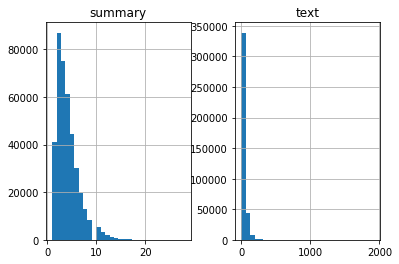

In [134]:
# showing the distribution of length of summary and length of text.
%matplotlib inline
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()


In [136]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9458130834941876


In [25]:
# used less value of max_text_len as training time is directly proportional to length.
max_text_len=30
max_summary_len=8

In [27]:
# only training on text reviews and summaries with lengths less than max_text_len and max_summary_len
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])
short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [31]:
#adding a start and end token to summaries
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [32]:
# splitting the data into train and test
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

## converting training and testing data into vectors

In [33]:

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [34]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.11028647495395
Total Coverage of rare words: 1.4450730144421176


In [35]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [36]:
x_voc

17489

In [37]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [38]:

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.99750324098527
Total Coverage of rare words: 2.592810080219758


In [39]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [40]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(192402, 192402)

In [137]:
## Removing all the entries where each vector has more than one non-zero value

In [41]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [42]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## Abstractive Model using LSTM and Attention Layer

In [68]:
from keras import backend as K 
K.clear_session() 
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      1748900     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [69]:
# compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [138]:
# different callbacks associated with the model.
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)]

In [71]:
# model.fit with training and testing data
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,\
                  epochs=50,callbacks=callbacks_list,batch_size=128, validation_data=([x_val,y_val[:,:-1]],\
                                    y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 189522 samples, validate on 21051 samples
Epoch 1/50
189440/189522 [============================>.] - ETA: 0s - loss: 2.7338
Epoch 00001: val_loss improved from inf to 2.47004, saving model to text_summarizer_4.h5
189522/189522 [==============================] - 187s 986us/sample - loss: 2.7338 - val_loss: 2.4700
Epoch 2/50
189440/189522 [============================>.] - ETA: 0s - loss: 2.4262
Epoch 00002: val_loss improved from 2.47004 to 2.32686, saving model to text_summarizer_4.h5
189522/189522 [==============================] - 175s 924us/sample - loss: 2.4262 - val_loss: 2.3269
Epoch 3/50
189440/189522 [============================>.] - ETA: 0s - loss: 2.3261
Epoch 00003: val_loss improved from 2.32686 to 2.25568, saving model to text_summarizer_4.h5
189522/189522 [==============================] - 175s 925us/sample - loss: 2.3261 - val_loss: 2.2557
Epoch 4/50
189440/189522 [============================>.] - ETA: 0s - loss: 2.2683
Epoch 00004: val_loss improved from 2.2

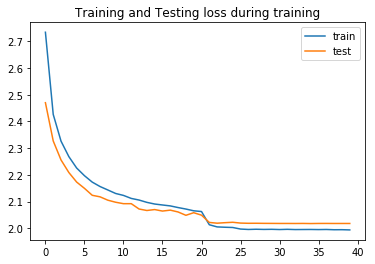

In [140]:
# plot of graph that shows the variation of training and testing loss during training phase.
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title("Training and Testing loss during training")
pyplot.show()

## Methods for generating summaries from the model

In [75]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [76]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [77]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [78]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### some examples to look at for our predicted summaries

In [141]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: great think might even better regular brownies good happy found 
Original summary: so good 
Predicted summary:  great brownies


Review: candies soft soft pepermint means melt mouth bite break apart bad sad buy another kind soft peppermint next go around 
Original summary: soft 
Predicted summary:  not as good as the original


Review: love bob red mill products grains blend ground included multigrain bread without grinding home pantry staple house price fantastic 
Original summary: makes great multigrain bread 
Predicted summary:  great product


Review: think product excellent came quickly used almost buy 
Original summary: excellent product 
Predicted summary:  great product


Review: quality extract unbelievable results great everyone always says something different makes results better 
Original summary: cake cookies pies 
Predicted summary:  great product


Review: recently started baking bread yeast perfect rises consistantly every time held great frozen 
Original summar

## Generating summaries for all the data

In [87]:
data2 = pd.read_csv("Reviews.csv")
data2.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [89]:
# preprocessing the data. 
cleaned_text2 = []
for t in data2['Text']:
    cleaned_text2.append(text_cleaner(t,0))
data2['cleaned_text']=cleaned_text2

In [92]:
# generating sequences for all the data and temp3 contains the final sequences
ctext1 = data2['cleaned_text']
ar_ctext1 = np.array(ctext1)
ar_temp_ctext    =   x_tokenizer.texts_to_sequences(ar_ctext1)
#padding zero upto maximum length
temp3   =   pad_sequences(ar_temp_ctext ,  maxlen=max_text_len, padding='post')

In [84]:
import pickle
from tqdm import tqdm

In [111]:
import random
predicted_summary2 = []
for i in tqdm(range(0,len(data2))):
    #print("Review:",data2.iloc[i]['Text'])
    #print("Orginal Summary:",data2.iloc[i]['Summary'])
    #print("predicted Summary:",get_predicted(temp_data.iloc[i]['cleaned_text']))
    #print("Predicted summary:",decode_sequence(temp3[i].reshape(1,max_text_len)))
    #print("\n")
    predicted_summary2.append(decode_sequence(temp3[i].reshape(1,max_text_len)))
    if((i!=0)and(i%100000==0)):
        with open('predicted_summary.pkl', 'wb') as f:
            pickle.dump(predicted_summary2, f)
            print("saved "+str(i/100000)+" times")

 18%|█▊        | 100004/568454 [1:26:28<7:01:56, 18.50it/s]

saved 1.0 times


 35%|███▌      | 200004/568454 [2:52:29<5:55:49, 17.26it/s]

saved 2.0 times


 53%|█████▎    | 300003/568454 [4:18:39<4:17:31, 17.37it/s] 

saved 3.0 times


 70%|███████   | 400003/568454 [5:44:38<2:52:01, 16.32it/s]

saved 4.0 times


 88%|████████▊ | 500004/568454 [7:10:30<1:14:27, 15.32it/s]

saved 5.0 times


100%|██████████| 568454/568454 [8:09:31<00:00, 19.35it/s]  


In [114]:
 with open('predicted_summary_final.pkl', 'wb') as f:
            pickle.dump(predicted_summary2, f)

In [119]:
data2['predicted_summary']=predicted_summary2
data2=data2.drop(columns=['cleaned_text'])

In [126]:
# finally writing into another csv with predicted_summary column which will be used by other models
data2.to_csv('Reviews_summaries.csv')

In [127]:
data3 = pd.read_csv('Reviews_summaries.csv')

In [131]:
data3.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,predicted_summary
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,good quality
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",peanuts
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",best almonds ever
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,not what expected
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great
